<img src="https://2wz2rk1b7g6s3mm3mk3dj0lh-wpengine.netdna-ssl.com/wp-content/uploads/2018/08/kinetica_logo.svg" alt="Kinetica Logo" width="300" align="left"/>

### The Database for Space and Time

# Generating Safer Workout Routes At Night

By Mina Negahban

Despite the many dangers associated with running at night, 68% of people do so regularly<sup>(1)</sup>. One of the challenges during a run is staying focused -- fears of what could be hiding in the dark can be distracting, and ultimately decrease one's performance. Running should not be stressful or fear inducing, it should be relaxing, or at the very least a time when you can focus completley on your self and your fitness. 

Our goal with this project is to generate safer routes for runners (or anyone out at night). The route will be optimized based on streetlight locations using Kinetica’s graph solver, to produce the most well lit path between the user’s specified origin and destination points. 

## Table of Contents:
- [Problem Setup](#problem-setup)
- [Caveats & Simplifying Assumptions](#caveats-simplifying-assumptions)
-  [Getting Started](#getting-started)
   * [Required Data](#required-data)
   * [Data Wrangling](#data-wrangling)
-  [Implementation](#implementation)
-  [Results](#results)
-  [Taking This Further](#taking-this-further)
-  [Further Reading](#further-reading)
-  [Documentation](#documentation)
-  [About Us](#about-us)
-  [Contact Us](#contact-us)

## Problem Setup

We set this problem up as a graph optimization with edge weights that favor the traversal of lit streets. We will create a light mask based on the intersections between lights (and their surrounding radius) and streets to enrich our road network data to determine whether each street segment is lit or not.

### Caveats & Simplifying Assumptions

* We currently assume that all lights are of the same luminosity, though that is not the case. Our dataset has luminosity attributes for some of the lights, but not all.
* We currently assume uniformly distributed light around the light source, though in reality there are often obstructions such as trees
* We currently do not add up luminosity from multiple overlapping lights, but we feel this would have a very minor effect on our results.

## Getting Started

To get started immediately, you can run everything below quickly on the [Developer Edition](https://www.kinetica.com/try/) or via [Kinetica Cloud](https://www.kinetica.com/kinetica-as-a-service-on-azure/)

Then, import this repo from GitHub:

```
	git clone git@github.com:kineticadb/saferun.git
	cd saferun
```

Set up python dependencies:

```
	pip install -r requirements.txt
```
Export your credentials as environment variables and the the [Jupyter notebook](https://github.com/kineticadb/saferoute/blob/master/start-here.ipynb) will lead you from start to finish!

```	
	export KINETICA_HOST='https://xyz.eastus.cloudapp.azure.com/abc/gpudb-0'
	export KINETICA_USER='kadmin'
	export KINETICA_PASS='xyz'
	jupyter notebook
```

In [ ]:
import gpudb
import os

We'll be interacting with Kinetica along the way to load data, set up graph optimziations, and view results. Make sure to export these environment variables (or override them below): **KINETICA_HOST, KINETICA_USER, KINETICA_PASS**. All the code below is Python, but many are SQL commands excuted via Python directly against the database you connect to below.

In [ ]:
KINETICA_HOST = os.getenv('KINETICA_HOST', "http://localhost:9191")
KINETICA_USER = os.getenv('KINETICA_USER', "kadmin")
KINETICA_PASS = os.getenv('KINETICA_PASS')
db = gpudb.GPUdb(host=KINETICA_HOST, username=KINETICA_USER, password=KINETICA_PASS)
exec_result = db.execute_sql_and_decode('show system properties')['status_info']['status']
print(exec_result)

### Required Data

We will be using two datasets to drive our optimizations:
* DC Street Light Dataset: https://opendata.dc.gov/datasets/DCGIS::street-lights/about
* DC Road Network Dataset: https://download.geofabrik.de/north-america/us/district-of-columbia.html

### Data Wrangling

After downloading the DC Road Network ZIP file, convert the file named **gis_osm_roads_free_1.shp** into a .csv file using gdal (https://gdal.org/):

`ogr2ogr -f CSV dcGeo.csv gis_osm_roads_free_1.shp -lco GEOMETRY=AS_WKT`

The street light data and converted road network data need to be on the database machine before they can be ingested. If using Kinetica Dev Edition, you can place them at `/mnt/persist` and if using Kinetica Cloud, they can be loaded via the KIFS upload screen. You can find more information here: https://docs.kinetica.com/7.1/tools/kifs/

Lets start with creating the target tables and loading our CSVs into them:

In [ ]:
exec_result = db.execute_sql("""
CREATE OR REPLACE TABLE "ki_home"."dc_streetlight_fixtures"
(
   "X" VARCHAR (128) NOT NULL,
   "Y" VARCHAR (64) NOT NULL,
   "ADDEDBY" VARCHAR (64, dict) NOT NULL,
   "ADDTOGIS" VARCHAR (128, dict) NOT NULL,
   "ARMLENGTH1_DESC" VARCHAR (64, dict) NOT NULL,
   "ARMLENGTH2_DESC" VARCHAR (64, dict),
   "ARMSTYLE_DESC" VARCHAR (128, dict) NOT NULL,
   "ASSETSTATUS_DESC" VARCHAR (64, dict) NOT NULL,
   "ASSETTYPE" VARCHAR (64, dict) NOT NULL,
   "CCT_DESC" VARCHAR (32, dict),
   "CONDITION_DESC" VARCHAR (128, dict),
   "CROSSSTREET" VARCHAR (128, dict) NOT NULL,
   "FACILITYID" VARCHAR (64) NOT NULL,
   "FEEDMANHOLE_DESC" VARCHAR (64, dict),
   "FIXTURESTYLE_DESC" VARCHAR (128, dict) NOT NULL,
   "GLOBALID" VARCHAR (32),
   "HOUSENO" VARCHAR (32, dict) NOT NULL,
   "INOPERATION" VARCHAR (128, dict) NOT NULL,
   "ISMETERED_DESC" VARCHAR (64, dict) NOT NULL,
   "ISMODIFIED_DESC" VARCHAR (64, dict),
   "LASTMODIFIED" VARCHAR (128, dict) NOT NULL,
   "LASTPAINTED" VARCHAR (128, dict) NOT NULL,
   "LEDINOPERATION" VARCHAR (128, dict) NOT NULL,
   "LIGHTHISTORY" VARCHAR,
   "LIGHTMANUFACTURER_DESC" VARCHAR (128, dict),
   "LIGHTTYPE_DESC" VARCHAR (128, dict) NOT NULL,
   "NUMBERLIGHTS" VARCHAR (64, dict) NOT NULL,
   "NUMBERARMS_DESC" VARCHAR (64, dict),
   "OBJECTID" VARCHAR (32) NOT NULL,
   "OTHEREQUIPMENT" VARCHAR (64, dict),
   "OWNER_DESC" VARCHAR (64, dict) NOT NULL,
   "PEPCOLIGHTID" VARCHAR (64),
   "POLECOLOR_DESC" VARCHAR (64, dict),
   "POLECOMPOSITION_DESC" VARCHAR (128, dict),
   "POLEHEIGHT_DESC" VARCHAR (64, dict) NOT NULL,
   "POLETYPE_DESC" VARCHAR (64, dict) NOT NULL,
   "POWERFEED_DESC" VARCHAR (64, dict) NOT NULL,
   "PROXIMITY_DESC" VARCHAR (64, dict),
   "QUADRANT_DESC" VARCHAR (64, dict) NOT NULL,
   "RMS_DESC" VARCHAR (64, dict),
   "ROADCLASSIFICATION_DESC" VARCHAR (128, dict),
   "SHIELD_DESC" VARCHAR (128, dict),
   "STREETLIGHTID" VARCHAR (64) NOT NULL,
   "STREETNAME" VARCHAR (128, dict) NOT NULL,
   "STREETSEGMID" VARCHAR (64),
   "TBASETYPE_DESC" VARCHAR (64, dict) NOT NULL,
   "TRAFFICCOMBO" VARCHAR (64, dict),
   "WARD" VARCHAR (32) NOT NULL,
   "WATTAGE1" VARCHAR (32, dict) NOT NULL,
   "WATTAGE2" VARCHAR (32, dict),
   "WHATMODIFIED" VARCHAR (256, dict),
   "WHYINACTIVE" VARCHAR (128, dict),
   "SUBBLOCKKEY" VARCHAR (128),
   "XCOORD" VARCHAR (32) NOT NULL,
   "YCOORD" VARCHAR (32) NOT NULL,
   "GIS_ID" VARCHAR (32),
   "GLOBALID_1" VARCHAR (256) NOT NULL,
   "CREATOR" VARCHAR (32),
   "CREATED" VARCHAR (128, dict) NOT NULL,
   "EDITOR" VARCHAR (32),
   "EDITED" VARCHAR (128, dict) NOT NULL
)
""")
exec_result['status_info']

In [ ]:
exec_result = db.execute_sql("""
CREATE OR REPLACE TABLE "ki_home"."dc_osm"
(
   "WKT" GEOMETRY NOT NULL,
   "osm_id" BIGINT NOT NULL,
   "code" INTEGER NOT NULL,
   "fclass" VARCHAR (64, dict) NOT NULL,
   "name" VARCHAR (256),
   "ref" VARCHAR (128, dict),
   "oneway" VARCHAR (32) NOT NULL,
   "maxspeed" INTEGER NOT NULL,
   "layer" INTEGER NOT NULL,
   "bridge" VARCHAR (32) NOT NULL,
   "tunnel" VARCHAR (32) NOT NULL
)
""")
exec_result['status_info']

In [ ]:
exec_result = db.execute_sql("""
LOAD DATA INTO ki_home.dc_streetlight_fixtures
FROM FILE PATHS 'data/Street_Lights_new.csv'
FORMAT TEXT (INCLUDES HEADER = false);
""")
exec_result['status_info']

In [ ]:
exec_result = db.execute_sql("""
ALTER COLUMN dc_streetlight_fixtures.X DOUBLE NOT NULL;
""")
exec_result['status_info']

In [ ]:
exec_result = db.execute_sql("""
ALTER COLUMN dc_streetlight_fixtures.Y DOUBLE NOT NULL;
""")
exec_result['status_info']

In [ ]:
exec_result = db.execute_sql("""
LOAD DATA INTO ki_home.dc_osm
FROM FILE PATHS 'data/dcGeo.csv'
FORMAT TEXT (INCLUDES HEADER = true);
""")
exec_result['status_info']

## Implementation 

### Prep Streetlight Data

First we must convert the street light points into polygons inorder to create buffers around the lights, which represents their lightspan.

In [ ]:
exec_result = db.execute_sql("""create table dc_buffer_ids
  AS (SELECT st_buffer(ST_POINT(ki_home.dc_streetlight_fixtures.X, ki_home.dc_streetlight_fixtures.Y), 9, '', 1), STREETLIGHTID
  FROM ki_home.dc_streetlight_fixtures);
  """)

This next step is only for demo purposes. We will create a filter to only look at a small subset of the data. You may skip this step if you are running a cloud instance. This is just to save time, so we don't have to go through the enitre data set for each query. If you do chose to skip this step, please make sure to change the table names that appear in the future steps from the ones we will create and refer to here.

In [ ]:
exec_result = db.execute_sql("""create or replace table fixtures_small
AS(
SELECT *
FROM ki_home.dc_streetlight_fixtures s
WHERE stxy_within(s.X, s.Y, ST_GEOMFROMTEXT(ST_GEOMFROMTEXT('POLYGON((-77.045831 38.933725, -77.000413 38.933725, -77.000413 38.902188, -77.045831 38.902188, -77.045831 38.933725))'))
)
);
""")

In [ ]:
exec_result = db.execute_sql("""create or replace table osm_small
AS(
SELECT *
FROM ki_home.dc_osm o
WHERE st_within(o.WKT, ST_GEOMFROMTEXT(ST_GEOMFROMTEXT('POLYGON((-77.045831 38.933725, -77.000413 38.933725, -77.000413 38.902188, -77.045831 38.902188, -77.045831 38.933725))'))
)
);
""")

In [ ]:
exec_result = db.execute_sql("""create or replace table dc_buffers_small
AS(
SELECT *
FROM ki_home.dc_buffer_ids b
WHERE st_within(b.EXPR_0, ST_GEOMFROMTEXT(ST_GEOMFROMTEXT('POLYGON((-77.045831 38.933725, -77.000413 38.933725, -77.000413 38.902188, -77.045831 38.902188, -77.045831 38.933725))'))
)
);
""")


Convert the polygons representing the street lights into a single multipolygon

In [ ]:
exec_result = db.execute_sql("""create table lights_single_poly
AS (SELECT st_dissolve(EXPR_0)
from dc_buffers_small
);
""")

Now we will perform a gejoin 

In [ ]:
exec_result = db.execute_sql("""
create table lightness
AS (SELECT 
  osm_id AS "osm_id",
  COUNT(*) AS "light"
FROM
  ki_home.osm_small
  JOIN ki_home.lights_single_poly
    ON ST_INTERSECTS(WKT, EXPR_0) = 1
GROUP BY
  osm_id
  );
""")


Next we will add a column to the road network data indicating the presence of light.

In [ ]:
exec_result = db.execute_sql("""
ALTER TABLE osm_small
ADD light int NOT NULL
DEFAULT 0;
""")

db.execute_sql("""
update osm_small os
set light = 1 
where osm_id=
(
SELECT osm_id
        FROM ki_home.lightness l
        WHERE os.osm_id = l.osm_id
        );
""")

### Graph

First we will create the graph with weights

In [ ]:
exec_result = db.create_graph(
    graph_name = "dc_osm_graph", 
    directed_graph = False,
    edges = [
    "ki_home.osm_small.osm_id AS EDGE_ID",
    "ki_home.osm_small.WKT AS EDGE_WKTLINE"
  ],
    weights = [
    "ki_home.osm_small.osm_id AS WEIGHTS_EDGE_ID",
    "ST_Length(ki_home.osm_small.WKT,1)/(ST_NPoints(ki_home.osm_small.WKT)-1) + ((1- ki_home.osm_small.light)*20) AS WEIGHTS_VALUESPECIFIED"
  ],
                              {
   
    "merge_tolerance": "0.00001",
    "use_rtree": "false",
    "min_x": "-180",
    "max_x": "180",
    "min_y": "-90",
    "max_y": "90",
    "recreate": "true",
    "modify": "false",
    "export_create_results": "false",
    "enable_graph_draw": "true",
    "save_persist": "false",
    "sync_db": "false",
    "add_table_monitor": "false",
    "graph_table": "ki_home.dc_osm_graph_table",
    "add_turns": "false",
    "turn_angle": "60.0",
    "is_partitioned": "false"
  
}
)
exec_result['status_info']


Now we will solve the graph using the shortest_path solver

In [ ]:
exec_result = db.solve_graph(
    graph_name = "dc_osm_graph",
    solver_type = "SHORTEST_PATH",
    source_nodes = [
    "{'POINT(-77.037124 38.926142)'} AS NODE_WKTPOINT"
  ],
    destination_nodes = [
    "{'POINT(-77.042686 38.922676)'} AS NODE_WKTPOINT"
  ],
    solution_table = "ki_home.dc_lit_path_solved",
    {
    "export_solve_results": "false",
    "min_solution_radius": "0.0",
    "max_solution_radius": "0.0",
    "max_solution_targets": "0",
    "accurate_snaps": "true",
    "left_turn_penalty": "0.0",
    "right_turn_penalty": "0.0",
    "intersection_penalty": "0.0",
    "sharp_turn_penalty": "0.0",
    "output_edge_path": "false",
    "output_wkt_path": "true"
  
}
)
exec_result['status_info']

## Results

Below is a before and after of the generated path based on the weights. The top image is the actual shortest path, with uniform weights set to 2 (``"uniform_weights": "2"``) during the time of graph solving. The bottom image is the generated safest path, with no changes to the weight expression already inputted during the graph creation, to account for the presence of lights on the streets. When overlapped with the layer of street lights (in Reveal) it is clear that the path we generated has more lights, and is thus safer, proving that our model is successful. The shortest path has 27 lights, while the safest has 38 lights. Based on these results it is also evident that our model prioritizes litness, over distance. The generated path is longer than the default shortest path, however it has 11 more light fixtures, making it the safer option. 

Here is a before and after of the generated path based on the wieghts.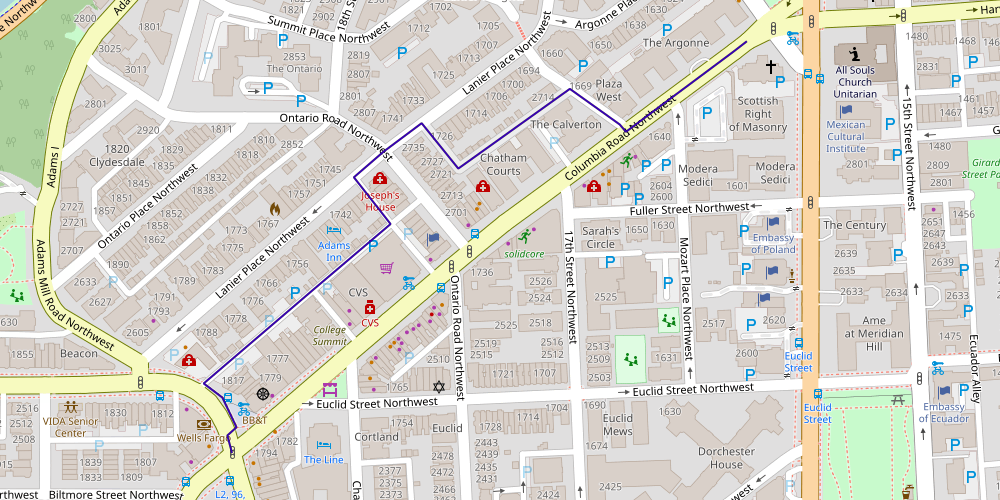 


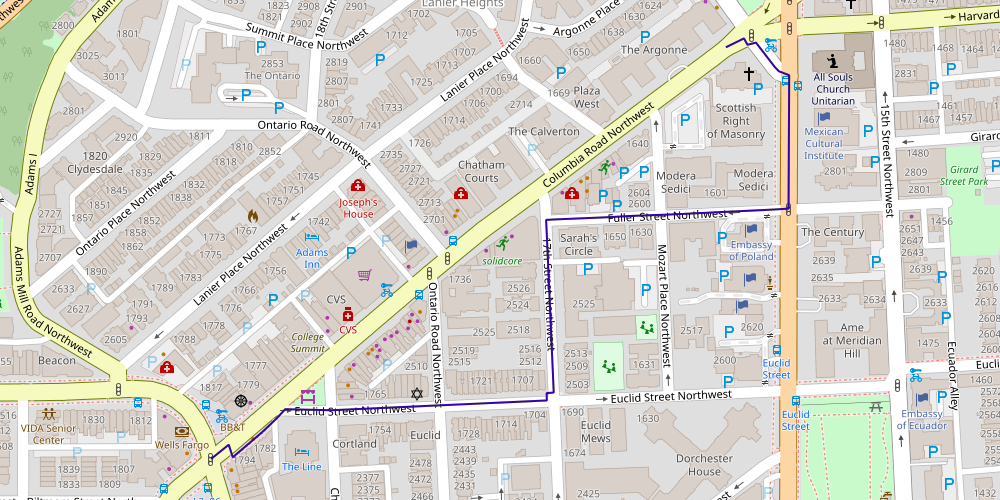

### Further Applications
More layers can be added to this model to generate even safer routes with more nuances. Additional wieghts can be added based on:
* Real time police reports 
    * This will also highlight Kinetica's capabilities with live streaming data ingest
* Cell coverage
* Streets with sidewalks/bikelanes
* CCTV locations
* Zone type
* Terrain type

This model does not have to be limited to only runner safety. Some examples of applications beyond running include:
* Hiking/biking routes
* Student safety on/sorrounding college campuses
* Parking at night

This model also has the potential to be scaled up to a bigger level such as state or nation wide, if you have the street light data to do so.

### References

1. Fuehrer, Dan, et al. “What Time of Day Do People Run?” *Runner's World*, 17 Sept. 2020, www.runnersworld.com/training/a20812346/what-time-of-day-do-people-run/. 

## Documentation
- [Full Documentation](https://docs.kinetica.com/7.1/)
- [Topic Based Quickstart Guides](https://docs.kinetica.com/7.1/guides/)

## About Us
Kinetica is an analytics database for fusing data across streams and data lakes to unlock value from spatial and temporal data at scale and speed. Learn about us [here](https://www.kinetica.com/).

## Contact Us
- Follow on Github: <a class="github-button" href="https://github.com/kineticadb" data-size="large" aria-label="Follow @kineticadb on GitHub">Follow @kineticadb</a>
- Email: [support@kinetica.com](mailto:support@kinetica.com)
- Slack: [Slack](https://www.kinetica.com/slack)
- Visit: [https://www.kinetica.com/contact/](https://www.kinetica.com/contact/)

## License

The software is licensed under the MIT license.